<a name="Imports-and-Logging-Configuration"></a>1. Imports and Logging Configuration
First, import all necessary libraries and configure the logging mechanism to monitor the training process.

In [11]:
## Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from tqdm import tqdm
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector

2. Data 

In [12]:
# Load MNIST Dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data
y = mnist.target.astype(int)

# Shuffle Dataset
X, y = shuffle(X, y, random_state=42)

# Use a Subset of Data for Faster Processing
subset_size = 5000  # Adjust as needed
X_subset = X[:subset_size]
y_subset = y[:subset_size]
print(f"Subset size: {subset_size} samples")

Loading MNIST dataset...
Subset size: 5000 samples


Normalise and padd data to fit $2^{10}$

In [14]:
# Normalize Data Vectors
print("Normalizing data vectors...")
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_subset)

# Pad or Truncate Data Vectors to Length 1024
num_qubits = 10
desired_length = 2 ** num_qubits  # 1024

X_padded = []
for x in X_scaled:
    x_padded = np.zeros(desired_length)
    length = min(len(x), desired_length)
    x_padded[:length] = x[:length]  # Truncate if necessary
    # Normalize the vector
    norm = np.linalg.norm(x_padded)
    if norm != 0:
        x_padded = x_padded / norm
    X_padded.append(x_padded)

X_padded = np.array(X_padded)
print("Done")

Normalizing data vectors...
Done


Amplitude Encoding

In [15]:
# Create Amplitude Encoding Circuits and Get Statevectors
print("Creating amplitude encoding circuits and obtaining statevectors...")
statevectors = []
for idx, x in enumerate(tqdm(X_padded, desc="Statevector Generation")):
    qc = QuantumCircuit(num_qubits)
    qc.initialize(x, qc.qubits)
    # Get the statevector
    state = Statevector.from_instruction(qc)
    statevectors.append(state.data)

Creating amplitude encoding circuits and obtaining statevectors...


Statevector Generation: 100%|██████████| 5000/5000 [15:28<00:00,  5.38it/s]


Kernel matrix
The kernel matrix, also known as the Gram matrix, is used to measure the similarity between data points in a high-dimensional feature space. For the quantum kernel, the elements of the kernel matrix are computed as follows:

$K_{ij} = | \langle \psi_i | \psi_j \rangle |^2$
where:
$|\psi_i\rangle$ and $|\psi_j\rangle$ are the statevectors obtained from quantum circuits initialized with the input data vectors $x_i$ and $x_j$.
$\langle \psi_i | \psi_j \rangle$ represents the inner product between the two quantum states.
The absolute square $| \langle \psi_i | \psi_j \rangle |^2$ gives a measure of similarity between the quantum states.


In matrix form, the kernel matrix $K$ can be represented as:


$K = 
\begin{bmatrix}
k(x_1, x_1) & k(x_1, x_2) & \cdots & k(x_1, x_n) \\
k(x_2, x_1) & k(x_2, x_2) & \cdots & k(x_2, x_n) \\
\vdots & \vdots & \ddots & \vdots \\
k(x_n, x_1) & k(x_n, x_2) & \cdots & k(x_n, x_n)
\end{bmatrix}$

where each element $k(x_i, x_j)$ is computed using the quantum state overlaps as described above.

In [16]:
# Compute the Kernel Matrix
print("Computing the kernel matrix...")
num_samples = len(statevectors)
K = np.zeros((num_samples, num_samples))

for i in tqdm(range(num_samples), desc="Computing Kernel Matrix"):
    for j in range(i, num_samples):
        overlap = np.dot(np.conj(statevectors[i]), statevectors[j])
        K_ij = np.abs(overlap) ** 2
        K[i, j] = K_ij
        K[j, i] = K_ij  # Kernel matrix is symmetric

Computing the kernel matrix...


Computing Kernel Matrix: 100%|██████████| 5000/5000 [01:29<00:00, 56.07it/s] 


Final preparation --> Data splitting 

In [17]:
# Split Dataset into Training and Testing Sets
print("Splitting dataset into training and testing sets...")
train_indices, test_indices = train_test_split(
    np.arange(len(y_subset)), test_size=0.2, random_state=42, stratify=y_subset
)

K_train = K[np.ix_(train_indices, train_indices)]
K_test = K[np.ix_(test_indices, train_indices)]

y_train = y_subset[train_indices]
y_test = y_subset[test_indices]

Splitting dataset into training and testing sets...


Train SVM

Support Vector Machines (SVMs) aim to find the optimal hyperplane that maximizes the margin between classes. When using a kernel method, the process involves utilizing a precomputed kernel matrix to efficiently train the model.

$\min_{\alpha} \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} \alpha_i \alpha_j y_i y_j k(x_i, x_j) - \sum_{i=1}^{n} \alpha_i$


subject to:

$0 \leq \alpha_i \leq C, \quad \sum_{i=1}^{n} \alpha_i y_i = 0$

where:
$\alpha_i$ are the Lagrange multipliers.
$C$ is the regularization parameter that controls the trade-off between maximizing the margin and minimizing classification error.
$y_i$ is the label for the data point $x_i$.
$k(x_i, x_j)$ is the kernel function value, obtained from the precomputed kernel matrix $K$.

Once trained, the decision function is used to classify new data points:
$f(x) = \sum_{i=1}^{n} \alpha_i y_i k(x_i, x) + b$

Here, $k(x_i, x)$ represents the similarity between the training point $x_i$ and the new data point $x$, as computed by the kernel function.

In [18]:
# Train SVM with Precomputed Kernel
print("Training SVM with precomputed kernel...")
clf = SVC(kernel='precomputed', probability=True)
clf.fit(K_train, y_train)

Training SVM with precomputed kernel...


SVC(kernel='precomputed', probability=True)

Accuracy

In [21]:
y_pred = clf.predict(K_test)
y_pred_prob = clf.predict_proba(K_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Evaluating the model...
Test Accuracy: 93.50%


In [22]:
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Classification Report:\n{classification_rep}")
print(f"Confusion Matrix:\n{conf_matrix}")

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        98
           1       0.97      0.98      0.98       110
           2       0.92      0.95      0.93        97
           3       0.92      0.93      0.92       111
           4       0.93      0.93      0.93        87
           5       0.93      0.88      0.91        95
           6       0.95      0.96      0.95        98
           7       0.94      0.91      0.93       103
           8       0.89      0.90      0.89        98
           9       0.92      0.92      0.92       103

    accuracy                           0.94      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.94      0.94      0.93      1000

Confusion Matrix:
[[ 96   0   0   0   0   0   0   0   2   0]
 [  0 108   1   0   0   0   0   0   0   1]
 [  0   0  92   1   0   1   0   0   3   0]
 [  0   0   3 103   0   0   0   1   4   0]
 [  0   0   0   0  81   0   

Plots

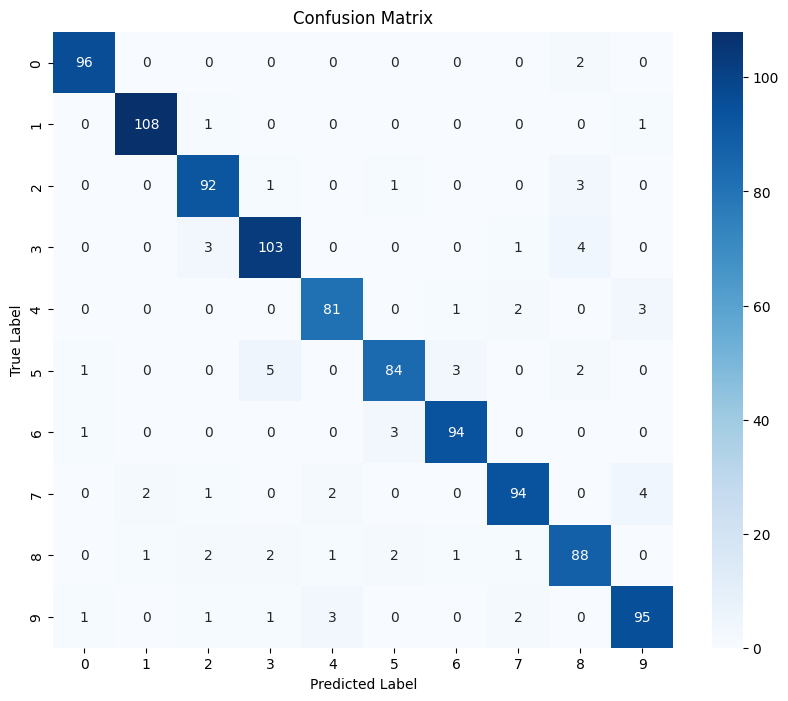

In [23]:
## Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The Receiver Operating Characteristic (ROC) curve is a tool used to evaluate the performance of a classification model. It shows the trade-off between the True Positive Rate (TPR) and the False Positive Rate (FPR) at various decision thresholds.

For the MNIST dataset, which has 10 classes, we use a one-vs-rest approach to compute the ROC curve for each class. The ROC curve is plotted by treating each class as the positive class and all other classes as negative.

The Area Under the Curve (AUC) is calculated for each class to provide a quantitative measure of the classifier's performance for that specific class. The AUC ranges from 0.5 (random guessing) to 1.0 (perfect classification).

Plotting ROC Curves for sample classes...


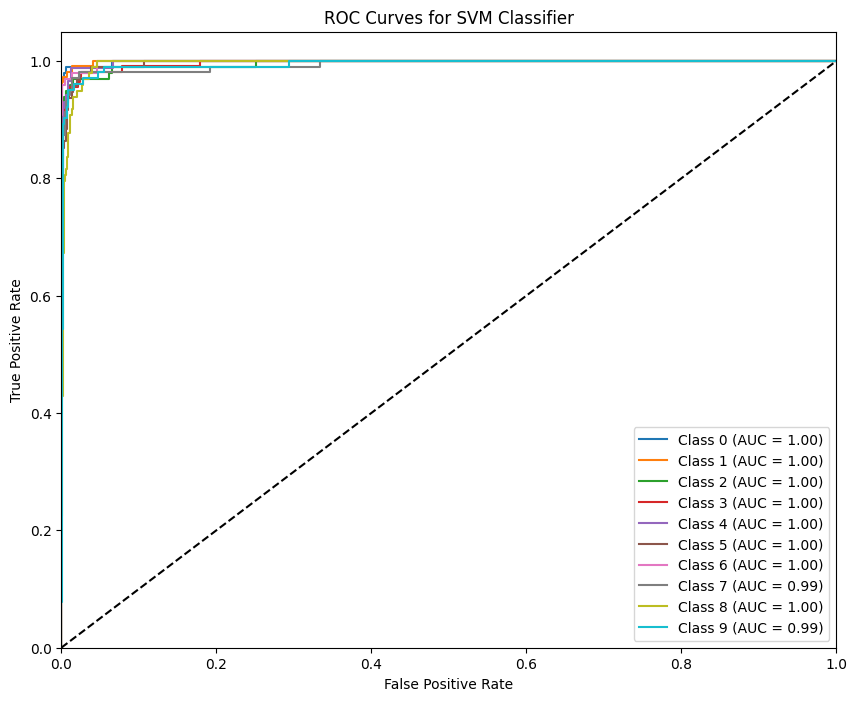

In [24]:
## ROC Curve for Sample Classes
print("Plotting ROC Curves for sample classes...")
plt.figure(figsize=(10, 8))
for i in range(10):
    if i in y_test:
        fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for SVM Classifier')
plt.legend(loc='lower right')
plt.show()